# ESR Function Matching Tutorial

This notebook demonstrates how to use the Exhaustive Symbolic Regression (ESR) library to:
1. Generate symbolic mathematical expressions
2. Match functions to target data through parameter optimization
3. Visualize and analyze results

ESR is a powerful tool for discovering mathematical relationships in data by systematically exploring the space of symbolic expressions.

## 1. Import Required Libraries

First, let's import all the necessary libraries for symbolic regression, numerical computation, and visualization.

In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import esr.generation.duplicate_checker as duplicate_checker
import os
import random
from scipy.optimize import minimize
import warnings

# Suppress all runtime warnings to clean up output
warnings.filterwarnings('ignore')
np.seterr(all='ignore')  # Suppress numpy warnings (divide by zero, overflow, etc.)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"SymPy version: {sympy.__version__}")

Libraries imported successfully!
NumPy version: 2.2.3
SymPy version: 1.14.0


## 2. Set Random Seed for Reproducibility

Setting a random seed ensures that our results are reproducible across different runs.

In [2]:
# Set random seed for reproducible comparison
np.random.seed(42)
random.seed(42)
print("Random seed set to 42 for reproducible results")

Random seed set to 42 for reproducible results


## 3. Generate Target Data

We'll create a target function and add some noise to simulate real-world data. Our target function is:

$$f(x) = x \cdot \sin(x) + 0.5x + \text{noise}$$

This is a moderately complex function that combines trigonometric and polynomial terms.

Generating functions with complexity 6 for run 'osc_maths'...

Target function: y = x * sin(x) + 0.5x
Evaluating functions over interval [0, 2π] with 100 points


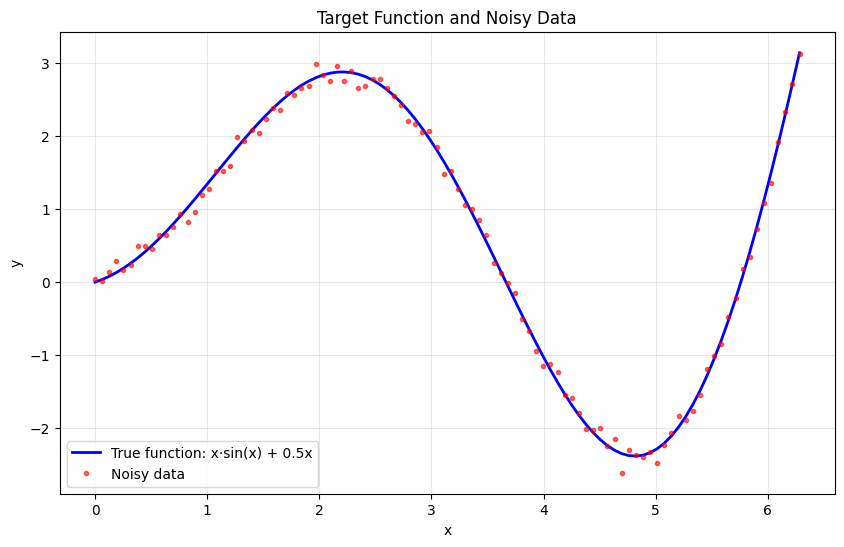

In [ ]:
# Define the true function we want to match
def true_function(x):
    return np.sin(x)*x + 0.5*x

# Create evaluation points in the interval [0, 2π]
x_eval = np.linspace(0, 2*np.pi, 100)
y_true = true_function(x_eval) + np.random.normal(0, 0.1, size=x_eval.shape)  # Add some noise

print(f"\nTarget function: y = x * sin(x) + 0.5x")
print(f"Evaluating functions over interval [0, 2π] with {len(x_eval)} points")

# Plot the target data
plt.figure(figsize=(10, 6))
plt.plot(x_eval, true_function(x_eval), 'b-', linewidth=2, label='True function: x⋅sin(x) + 0.5x')
plt.plot(x_eval, y_true, 'ro', markersize=3, alpha=0.6, label='Noisy data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target Function and Noisy Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Generate Symbolic Expressions with ESR

ESR generates mathematical expressions by systematically combining mathematical operations and functions. We'll generate expressions of complexity 6, which provides a good balance between expressiveness and computational efficiency.

The process involves:
1. **Generation**: Create all possible expression trees of given complexity
2. **Simplification**: Remove mathematically equivalent expressions
3. **Deduplication**: Eliminate duplicate expressions

In [4]:
# Set up parameters for function generation
complexity = 6
# Use a predefined runname from the ESR library that includes sine functions
runname = "osc_maths"

print(f"Generating functions with complexity {complexity} for run '{runname}'...")


# Generate and process equations using the main entry point from the library
try:
    duplicate_checker.main(runname, complexity)
except SystemExit:
    # The duplicate_checker.main function calls quit(), so we catch the SystemExit
    pass

print("\nFunction generation and processing complete.")

# Read the generated functions from the file
# The files are saved in the ESR library's function_library directory
import esr.generation.generator as generator
library_dir = os.path.abspath(os.path.join(os.path.dirname(generator.__file__), '..', 'function_library'))
eq_filename = os.path.join(library_dir, runname, f"compl_{complexity}", f"unique_equations_{complexity}.txt")
try:
    with open(eq_filename, "r") as f:
        all_functions = [line.strip() for line in f.readlines() if line.strip()]
except FileNotFoundError:
    print(f"Could not find file with generated equations: {eq_filename}")
    exit()

if not all_functions:
    print("No functions were generated. Exiting.")
    exit()

print(f"Found {len(all_functions)} unique functions.")

# Show some example expressions
print("\nExample generated expressions:")
for i, func_string in enumerate(all_functions[:10]):
    print(f"  {i+1}. {func_string}")
    
if len(all_functions) > 10:
    print(f"  ... and {len(all_functions)-10} more expressions")

Generating functions with complexity 6 for run 'osc_maths'...

Number of topologies: 21
[1 1 1 1 1 0] 64
[1 1 1 2 0 0] 160
[1 1 2 0 1 0] 160
[1 1 2 1 0 0] 160
[1 2 0 1 1 0] 160
[1 2 0 2 0 0] 400
[1 2 1 0 1 0] 160
[1 2 1 1 0 0] 160
[1 2 2 0 0 0] 400
[2 0 1 1 1 0] 160
[2 0 1 2 0 0] 400
[2 0 2 0 1 0] 400
[2 0 2 1 0 0] 400
[2 1 0 1 1 0] 160
[2 1 0 2 0 0] 400
[2 1 1 0 1 0] 160
[2 1 1 1 0 0] 160
[2 1 2 0 0 0] 400
[2 2 0 0 1 0] 400
[2 2 0 1 0 0] 400
[2 2 1 0 0 0] 400

Original number of trees: 5664
1 of 21
2 of 21
3 of 21
4 of 21
5 of 21
6 of 21
7 of 21
8 of 21
9 of 21
10 of 21
11 of 21
12 of 21
13 of 21
14 of 21
15 of 21
16 of 21
17 of 21
18 of 21
19 of 21
20 of 21
21 of 21

New number of trees: 6088

Max number of parameters: 3

Getting extra_orig indices

Sympy simplify

Saving all equations

Max number of parameters: 3
Optimisation 0 6088 6088
	Getting unique functions
	Getting unique sympy
	Getting unique inverse subs
		nparam = 0
		nparam = 1
		nparam = 2
		nparam = 3
	Making dict
	Prin

## 5. Parameter Optimization

Many of the generated expressions contain free parameters (like `a0`, `a1`, etc.). We need to optimize these parameters to best fit our target data.

The optimization process:
1. **Identify parameters** in each expression
2. **Create objective function** (mean squared error)
3. **Optimize parameters** using scipy's minimize function
4. **Evaluate fit quality** using MSE

In [5]:
def create_objective_function(expr_template, param_symbols, x_vals, y_target):
    """Create an objective function for parameter optimization"""
    def objective(params):
        try:
            # Suppress warnings during function evaluation
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                # Substitute parameters into expression
                substitutions = {param: params[i] for i, param in enumerate(param_symbols)}
                expr_with_params = expr_template.subs(substitutions)
                
                # Convert to callable and evaluate
                callable_func = sympy.lambdify([sympy.Symbol('x')], expr_with_params, modules=['numpy'])
                y_pred = callable_func(x_vals)
                
                # Check for invalid values
                if np.any(np.isinf(y_pred)) or np.any(np.isnan(y_pred)):
                    return 1e10  # Large penalty for invalid values
                    
                # Return mean squared error
                return np.mean((y_pred - y_target) ** 2)
        except:
            return 1e10  # Large penalty for any errors
    return objective

print("Objective function creation utility defined.")

Objective function creation utility defined.


In [6]:
# Evaluate all functions and find the best match with optimized parameters
best_function = None
best_error = float('inf')
best_callable = None
best_expr = None
best_params = None
valid_functions = 0
errors = []
function_results = []  # Store (error, function_string, optimized_expr) tuples

print(f"\nEvaluating {len(all_functions)} functions with parameter optimization...")

# Suppress warnings during the entire optimization process
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for i, func_string in enumerate(all_functions):
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(all_functions)} functions...")
        
        try:
            # Convert the string to a sympy expression
            x = sympy.symbols('x', real=True)
            # Create parameter symbols a0, a1, a2, etc.
            a_symbols = sympy.symbols([f'a{i}' for i in range(10)], real=True)
            
            # Define locals for sympy to understand the function string
            locs = {'x': x, 'sin': sympy.sin, 'cos': sympy.cos, 'inv': lambda x: 1/x, 
                    'Abs': sympy.Abs, 'pow': sympy.Pow, 'exp': sympy.exp, 'log': sympy.log}
            
            # Add parameter symbols to locs
            for j, a_sym in enumerate(a_symbols):
                locs[f'a{j}'] = a_sym

            # Parse the function string
            expr_template = sympy.sympify(func_string, locals=locs)
            
            # Check if the expression has any parameter symbols
            param_symbols = [sym for sym in expr_template.free_symbols if str(sym).startswith('a')]
            
            if param_symbols:
                # Optimize parameters
                # Initial guess for parameters
                initial_params = np.ones(len(param_symbols))
                
                # Create objective function
                objective = create_objective_function(expr_template, param_symbols, x_eval, y_true)
                
                # Optimize parameters with bounds to prevent extreme values
                bounds = [(-10, 10) for _ in param_symbols]  # Reasonable bounds for parameters
                
                try:
                    result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B', 
                                    options={'maxfun': 1000})
                    
                    if result.success:
                        # Use optimized parameters
                        optimized_params = result.x
                        mse = result.fun
                        
                        # Create final expression with optimized parameters
                        substitutions = {param: optimized_params[j] for j, param in enumerate(param_symbols)}
                        final_expr = expr_template.subs(substitutions)
                        final_callable = sympy.lambdify([x], final_expr, modules=['numpy'])
                        
                    else:
                        # Optimization failed, skip this function
                        continue
                        
                except:
                    # Optimization failed, skip this function
                    continue
                    
            else:
                # No parameters to optimize
                try:
                    final_callable = sympy.lambdify([x], expr_template, modules=['numpy'])
                    y_pred = final_callable(x_eval)
                    
                    # Check for invalid values
                    if np.any(np.isinf(y_pred)) or np.any(np.isnan(y_pred)):
                        continue
                        
                    mse = np.mean((y_pred - y_true) ** 2)
                    final_expr = expr_template
                    optimized_params = None
                    
                except:
                    continue
            
            # Record results
            errors.append(mse)
            function_results.append((mse, func_string, final_expr))
            
            # Check if this is the best function so far
            if mse < best_error:
                best_error = mse
                best_function = func_string
                best_callable = final_callable
                best_expr = final_expr
                best_params = optimized_params
                
            valid_functions += 1
                
        except Exception:
            # Function parsing failed
            continue

print(f"\nEvaluation complete!")
print(f"Successfully evaluated {valid_functions} out of {len(all_functions)} functions")

if best_function is None:
    print("No valid function found that could be evaluated.")
else:
    print(f"\nBest matching function:")
    print(f"Function string: {best_function}")
    print(f"Optimized expression: {best_expr}")
    if best_params is not None:
        print(f"Optimized parameters: {[f'{val:.4f}' for val in best_params]}")
    else:
        print("No parameters to optimize (function has no free parameters)")
    print(f"Mean Squared Error: {best_error:.6f}")


Evaluating 1605 functions with parameter optimization...
Processed 100/1605 functions...
Processed 200/1605 functions...
Processed 300/1605 functions...
Processed 400/1605 functions...
Processed 500/1605 functions...
Processed 600/1605 functions...
Processed 700/1605 functions...
Processed 800/1605 functions...
Processed 900/1605 functions...
Processed 1000/1605 functions...
Processed 1100/1605 functions...
Processed 1200/1605 functions...
Processed 1300/1605 functions...
Processed 1400/1605 functions...
Processed 1500/1605 functions...
Processed 1600/1605 functions...

Evaluation complete!
Successfully evaluated 1286 out of 1605 functions

Best matching function:
Function string: x*(a0 + sin(x))
Optimized expression: x*(sin(x) + 0.498090362570426)
Optimized parameters: ['0.4981']
Mean Squared Error: 0.008225


## 6. Analyze Results

Now let's sort the results by their mean squared error (MSE) and examine the best-performing expressions.

In [7]:
# Show statistics about all evaluated functions
if len(errors) > 0:
    errors = np.array(errors)
    print(f"\nStatistics for all {len(errors)} valid functions:")
    print(f"Best (lowest) MSE: {np.min(errors):.6f}")
    print(f"Worst (highest) MSE: {np.max(errors):.6f}")
    print(f"Mean MSE: {np.mean(errors):.6f}")
    print(f"Median MSE: {np.median(errors):.6f}")
    print(f"Standard deviation of MSE: {np.std(errors):.6f}")
    
    # Show top 5 best functions using the properly tracked results
    sorted_results = sorted(function_results, key=lambda x: x[0])  # Sort by MSE
    print(f"\nTop 5 best matching functions:")
    for i in range(min(5, len(sorted_results))):
        mse, func_string, optimized_expr = sorted_results[i]
        print(f"{i+1}. MSE = {mse:.6f}")
        print(f"   Original: {func_string}")
        print(f"   Optimized: {optimized_expr}")
        print()


Statistics for all 1286 valid functions:
Best (lowest) MSE: 0.008225
Worst (highest) MSE: 1597064293756161122651787145025362600777677186436619534077143918852968958136221381494095334562359551332126636205246120420903958333335139340126431815422628983384030778001159843909622954456811920439388405760.000000
Mean MSE: 1241885147694552343666458357588544527568022117180224301769061325946453735300596156644292552666344678039978352454045861047928745162030131272626795174440988443686595738003199604901480603949294092292194304.000000
Median MSE: 3.269296
Standard deviation of MSE: inf

Top 5 best matching functions:
1. MSE = 0.008225
   Original: x*(a0 + sin(x))
   Optimized: x*(sin(x) + 0.498090362570426)

2. MSE = 0.478385
   Original: a0 - pow(Abs(a1),sin(x))
   Optimized: 2.2785626974395 - 0.208628952441799**sin(x)

3. MSE = 0.748553
   Original: a1*(a0 - sin(x))
   Optimized: 2.11986078186208*sin(x) + 0.570744030356503

4. MSE = 0.748553
   Original: a1*(a0 + sin(x))
   Optimized: 2.1198613674553

## 7. Evaluate and Visualize the Best Function

Let's create a detailed visualization comparing our best-found function with the target function.

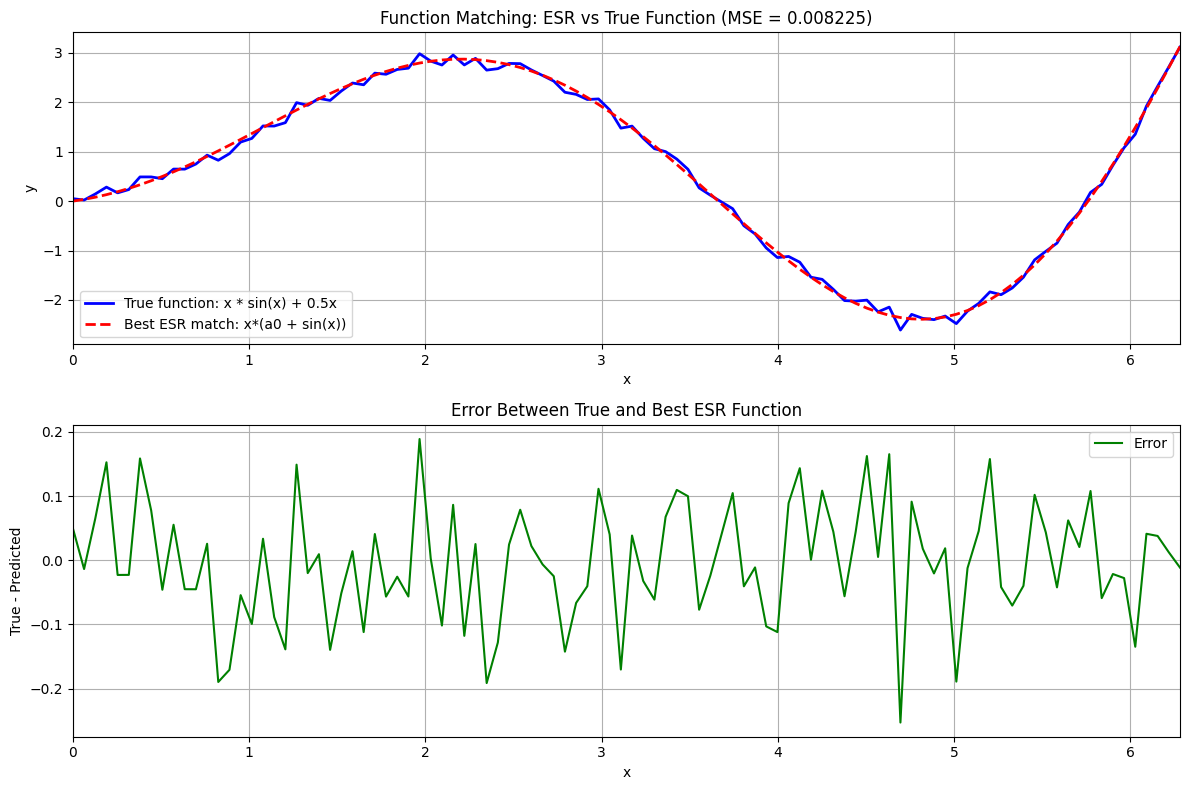


Plot saved as function_matching_example.png


In [8]:
# Plot the results
x_plot = x_eval
y_true_plot = y_true
y_best_plot = best_callable(x_plot)

plt.figure(figsize=(12, 8))

# Main plot
plt.subplot(2, 1, 1)
plt.plot(x_plot, y_true_plot, 'b-', linewidth=2, label='True function: x * sin(x) + 0.5x')
plt.plot(x_plot, y_best_plot, 'r--', linewidth=2, label=f'Best ESR match: {best_function}')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Function Matching: ESR vs True Function (MSE = {best_error:.6f})')
plt.legend()
plt.grid(True)
plt.xlim(0, 2*np.pi)

# Error plot
plt.subplot(2, 1, 2)
error_plot = y_true_plot - y_best_plot
plt.plot(x_plot, error_plot, 'g-', linewidth=1.5, label='Error')
plt.xlabel('x')
plt.ylabel('True - Predicted')
plt.title('Error Between True and Best ESR Function')
plt.legend()
plt.grid(True)
plt.xlim(0, 2*np.pi)

plt.tight_layout()
plot_filename = 'function_matching_example.png'
plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as {plot_filename}")

## 8. Summary

Let's complete the analysis and show where the generated equations are stored.

In [9]:
print(f"\nExample complete. Generated equations are stored in: {library_dir}/{runname}/compl_{complexity}/")


Example complete. Generated equations are stored in: /Users/amk/cosmocodes/ESR/esr/function_library/osc_maths/compl_6/
